Загрузка MNIST
Размер обуч выборки: X=(60000, 784), Y=(60000, 10)
Размер тест выборки: X=(10000, 784), Y=(10000, 10)

Начало обучения: 20 эпох, размер батча 64, скорость обучения 0.1
Эпоха 1/20 - Потери: 0.5444 - Точность на тесте: 0.9176
Эпоха 2/20 - Потери: 0.2432 - Точность на тесте: 0.9396
Эпоха 3/20 - Потери: 0.1868 - Точность на тесте: 0.9536
Эпоха 4/20 - Потери: 0.1521 - Точность на тесте: 0.9601
Эпоха 5/20 - Потери: 0.1283 - Точность на тесте: 0.9647
Эпоха 6/20 - Потери: 0.1095 - Точность на тесте: 0.9594
Эпоха 7/20 - Потери: 0.0962 - Точность на тесте: 0.9683
Эпоха 8/20 - Потери: 0.0854 - Точность на тесте: 0.9696
Эпоха 9/20 - Потери: 0.0761 - Точность на тесте: 0.9735
Эпоха 10/20 - Потери: 0.0690 - Точность на тесте: 0.9726
Эпоха 11/20 - Потери: 0.0628 - Точность на тесте: 0.9752
Эпоха 12/20 - Потери: 0.0569 - Точность на тесте: 0.9757
Эпоха 13/20 - Потери: 0.0524 - Точность на тесте: 0.9771
Эпоха 14/20 - Потери: 0.0482 - Точность на тесте: 0.9763
Эпоха 15/20 - Потери: 0.0441

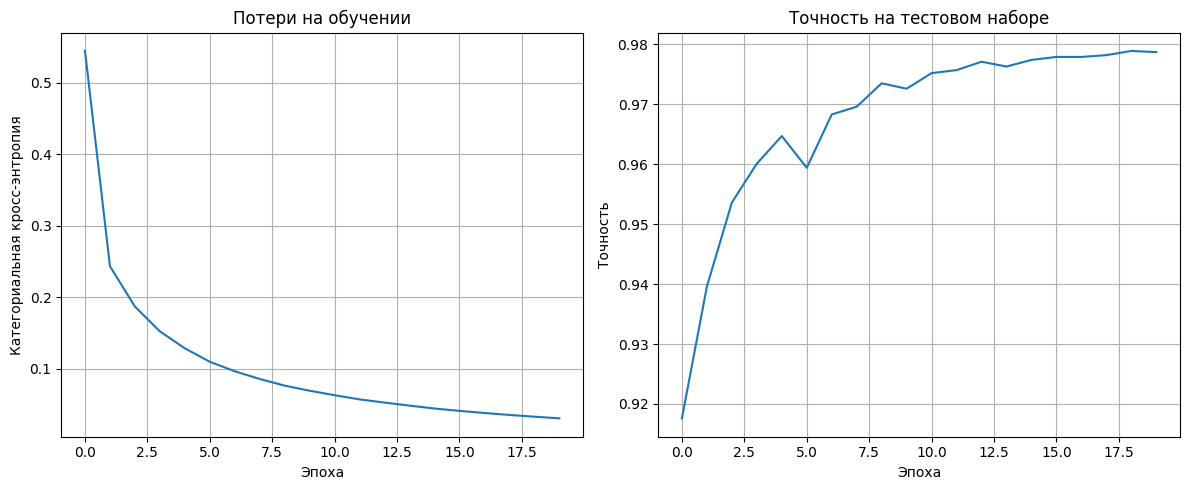

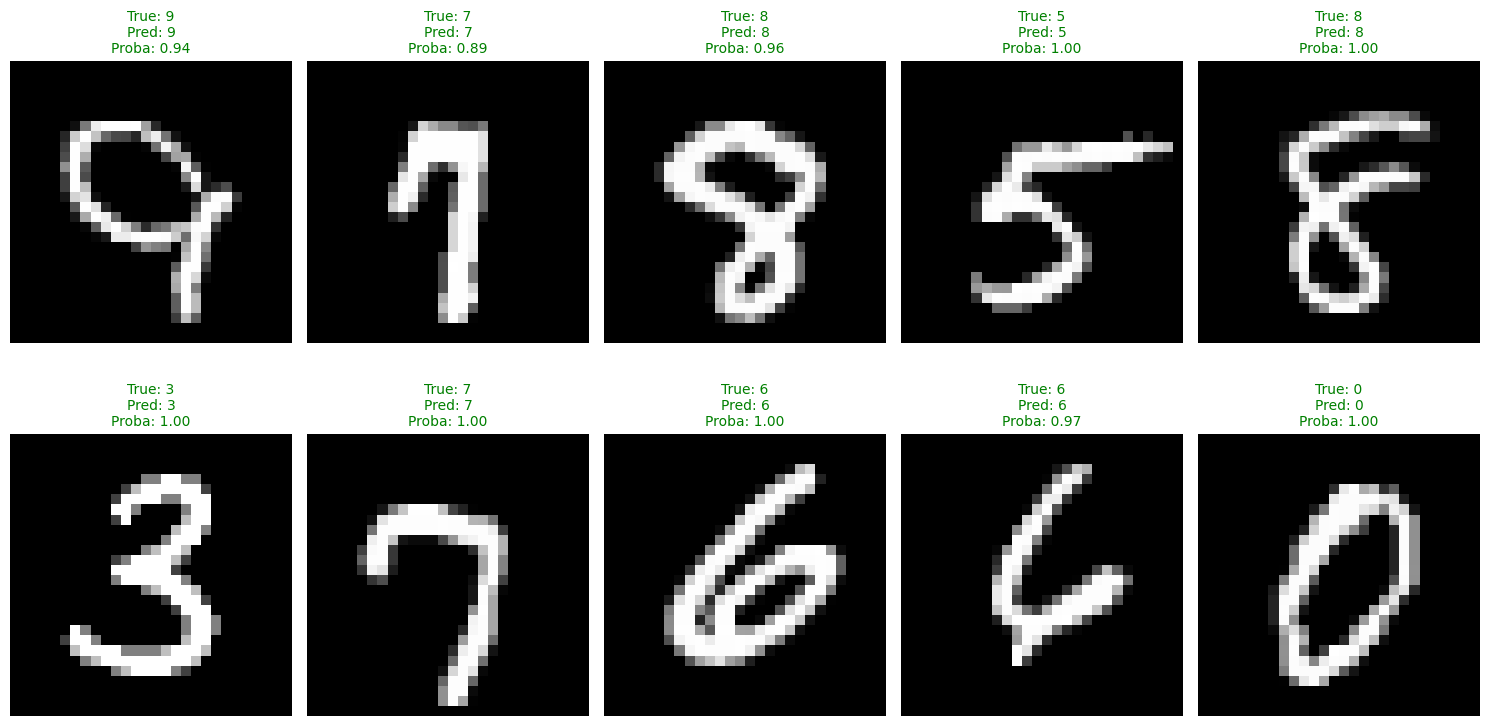

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class NeuralNetwork:
    """Реализация двухслойной нейронной сети для классификации изображений MNIST"""

    def __init__(self, input_size, hidden_size, output_size):
        """Инициализация весов и смещений"""
        # Инициализация весов нормальным распределением
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        # Для хранения промежуточных результатов
        self.hist = {}
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, z):
        """Функция активации ReLU"""
        return np.maximum(0, z)

    def relu_derivative(self, z):
        """Производная функции ReLU"""
        return np.where(z > 0, 1, 0)

    def softmax(self, z):
        """Функция активации softmax с защитой от переполнения"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def categorical_cross_entropy(self, y_pred, y_true):
        """Функция потерь - категориальная кросс-энтропия"""
        m = y_true.shape[0]  # количество примеров
        log = -np.log(y_pred[np.arange(m), np.argmax(y_true, axis=1)])
        loss = np.sum(log) / m
        return loss

    def forward(self, X):
        """Прямое распространение"""
        # Скрытый слой
        self.hist['Z1'] = X @ self.W1 + self.b1
        self.hist['A1'] = self.relu(self.hist['Z1'])

        # Выходной слой
        self.hist['Z2'] = self.hist['A1'] @ self.W2 + self.b2
        A2 = self.softmax(self.hist['Z2'])
        self.hist['A2'] = A2
        return A2

    def backward(self, X, y_true):
        """Обратное распространение ошибки"""
        m = X.shape[0]
        A1 = self.hist['A1']
        A2 = self.hist['A2']
        Z1 = self.hist['Z1']

        # Градиенты выходного слоя
        dZ2 = A2 - y_true
        self.dW2 = (1/m) * (A1.T @ dZ2)
        self.db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        # Градиенты скрытого слоя
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(Z1)
        self.dW1 = (1/m) * (X.T @ dZ1)
        self.db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    def update_parameters(self, learning_rate):
        """Обновление весов и смещений"""
        self.W1 -= learning_rate * self.dW1
        self.b1 -= learning_rate * self.db1
        self.W2 -= learning_rate * self.dW2
        self.b2 -= learning_rate * self.db2

    def predict(self, X):
        """Предсказание классов"""
        A2 = self.forward(X)
        return np.argmax(A2, axis=1)

    def predict_proba(self, X):
        """Предсказание вероятностей классов"""
        A2 = self.forward(X)
        return A2

    def evaluate(self, X_test, y_test_orig):
        """Оценка точности модели"""
        predictions = self.predict(X_test)
        accuracy = np.mean(predictions == y_test_orig)
        return accuracy

    def train(self, X_train, y_train, X_test, y_test_orig,
              epochs=20, batch_size=64, learning_rate=0.1):
        """Обучение модели"""
        print(f"\nНачало обучения: {epochs} эпох, размер батча {batch_size}, скорость обучения {learning_rate}")

        for epoch in range(epochs):
            epoch_loss = 0
            indices = np.random.permutation(X_train.shape[0])
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]

                # Прямое и обратное распространение
                y_pred_batch = self.forward(X_batch)
                loss = self.categorical_cross_entropy(y_pred_batch, y_batch)
                epoch_loss += loss * X_batch.shape[0]

                self.backward(X_batch, y_batch)
                self.update_parameters(learning_rate)

            # Расчет средней потери и точности
            avg_epoch_loss = epoch_loss / X_train.shape[0]
            self.loss_history.append(avg_epoch_loss)

            accuracy = self.evaluate(X_test, y_test_orig)
            self.accuracy_history.append(accuracy)

            print(f"Эпоха {epoch+1}/{epochs} - Потери: {avg_epoch_loss:.4f} - Точность на тесте: {accuracy:.4f}")

        final_accuracy = self.evaluate(X_test, y_test_orig)
        print(f"\nИтоговая точность на тестовом наборе: {final_accuracy:.4f}")

    def plot_training_history(self):
        """Визуализация процесса обучения"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Потери')
        plt.title('Потери на обучении')
        plt.xlabel('Эпоха')
        plt.ylabel('Категориальная кросс-энтропия')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy_history, label='Точность')
        plt.title('Точность на тестовом наборе')
        plt.xlabel('Эпоха')
        plt.ylabel('Точность')
        plt.grid(True)

        plt.tight_layout()
        plt.show()


def load_mnist_data():
    """Загрузка и предобработка данных MNIST"""
    print("Загрузка MNIST")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Нормализация изображений
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Преобразование в одномерные векторы
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)

    # Преобразование меток в one-hot encoding
    y_train_one_hot = to_categorical(y_train, 10)
    y_test_one_hot = to_categorical(y_test, 10)

    print(f"Размер обуч выборки: X={x_train_flat.shape}, Y={y_train_one_hot.shape}")
    print(f"Размер тест выборки: X={x_test_flat.shape}, Y={y_test_one_hot.shape}")

    return x_train_flat, y_train_one_hot, x_test_flat, y_test_one_hot, y_test, x_test


def visualize_predictions(model, x_test, y_test, x_test_flat, num_images=10):
    """Визуализация предсказаний модели на тестовых изображениях"""
    # Выбираем случайные изображения из тестового набора
    indices = np.random.choice(range(len(x_test)), num_images, replace=False)
    sample_images = x_test[indices]
    sample_labels = y_test[indices]
    sample_images_flat = x_test_flat[indices]

    # Получаем предсказания модели
    predictions = model.predict(sample_images_flat)
    proba = model.predict_proba(sample_images_flat)

    # Создаем график
    plt.figure(figsize=(15, 8))
    rows = int(np.ceil(num_images / 5))

    for i in range(num_images):
        plt.subplot(rows, 5, i+1)

        # Отображаем изображение
        plt.imshow(sample_images[i], cmap='gray')
        plt.axis('off')

        # Определяем цвет текста в зависимости от правильности предсказания
        pred_color = 'green' if predictions[i] == sample_labels[i] else 'red'

        # Добавляем информацию о предсказании
        title = f"True: {sample_labels[i]}\nPred: {predictions[i]}\nProba: {proba[i][predictions[i]]:.2f}"
        plt.title(title, color=pred_color, fontsize=10)

    plt.tight_layout()
    plt.show()


def main():
    """Основная функция для обучения и оценки модели"""
    # Параметры модели
    INPUT_SIZE = 784  # 28x28 пикселей
    HIDDEN_SIZE = 128
    OUTPUT_SIZE = 10  # 10 классов (цифры 0-9)
    LEARNING_RATE = 0.1
    EPOCHS = 20
    BATCH_SIZE = 64

    # Загрузка данных
    x_train, y_train_one_hot, x_test_flat, y_test_one_hot, y_test, x_test = load_mnist_data()

    # Создание и обучение модели
    model = NeuralNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
    model.train(x_train, y_train_one_hot, x_test_flat, y_test,
                epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

    # Визуализация результатов обучения
    model.plot_training_history()

    # Визуализация предсказаний на тестовых изображениях
    visualize_predictions(model, x_test, y_test, x_test_flat, num_images=10)


if __name__ == "__main__":
    main()